# Variational Non-linear LFM

In order to run this notebook yourself, you will need the dataset located here:
- Go to https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE100099

- Download the file `GSE100099_RNASeqGEO.tsv.gz`

In [1]:
import torch

from lafomo.utilities.torch import save, load

from lafomo.variational.models import NonLinearLFM, ExponentialLFM
from lafomo.variational.trainer import TranscriptionalTrainer
from lafomo.variational.kernels import RBF
from lafomo.configuration import VariationalConfiguration
from lafomo.datasets import HafnerData
from lafomo.plot import Plotter

from matplotlib import pyplot as plt

import numpy as np


13
tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.]) tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])


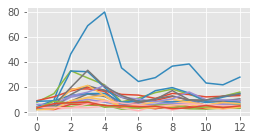

In [2]:
dataset = HafnerData(replicate=0, data_dir='../../../data/', extra_targets=False)
num_replicates = 1
num_genes = len(dataset.gene_names)
num_tfs = 1
num_times = dataset[0][0].shape[0]
print(num_times)
print(dataset[0][0], dataset.t)
t_inducing = torch.linspace(0, 12, num_times, dtype=torch.float64)
t_observed = torch.linspace(0, 12, num_times)
t_predict = torch.linspace(-2, 14, 80, dtype=torch.float64)

m_observed = torch.stack([
    dataset[i][1] for i in range(num_genes*num_replicates)
]).view(num_replicates, num_genes, num_times)

plt.figure(figsize=(4, 2))
for i in range(22):
    plt.plot(dataset[i][1])

In [4]:
config = VariationalConfiguration(
    learn_inducing=False,
    num_samples=50,
    kernel_scale=False,
    initial_conditions=True
)

kernel = RBF(num_tfs, scale=config.kernel_scale, dtype=torch.float64)
model = NonLinearLFM(num_tfs, config, kernel, t_inducing, dataset)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)
trainer = TranscriptionalTrainer(model, optimizer, dataset)
plotter = Plotter(model, np.array(dataset.gene_names))
print(dataset.num_outputs)

22


C:\Users\Jacob\Documents\proj\reggae\lafomo\variational\models\model.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.inducing_inputs = Parameter(torch.tensor(t_inducing), requires_grad=config.learn_inducing)
C:\Users\Jacob\Documents\proj\reggae\lafomo\variational\models\model.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.initial_conditions = Parameter(torch.tensor(torch.zeros(self.num_outputs, 1)), requires_grad=True)


### Outputs prior to training:

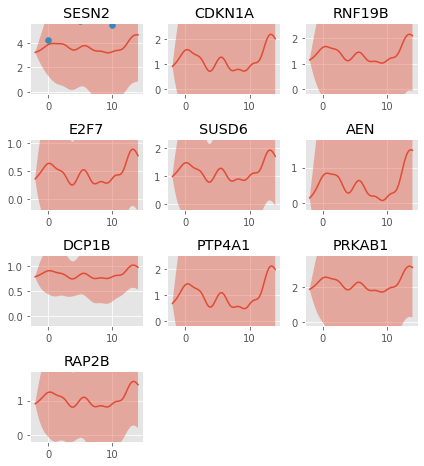

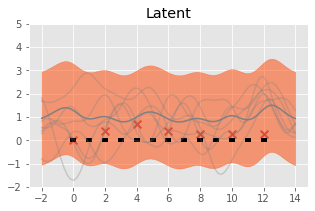

In [5]:
rtol = 5e-2
atol = rtol/10

model_kwargs = {
    'rtol': rtol, 'atol': atol
}

plotter.plot_outputs(t_predict, t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 5), plot_barenco=True, plot_inducing=False)

In [6]:
tol = 1e-1
# trainer = Trainer(optimizer)
output = trainer.train(200, rtol=tol, atol=tol/10, report_interval=5)

Epoch 001/200 - Loss: 15336.67 (15336.67  0.00  ) λ: 0.97 b: 0.66 d 0.14 s: 0.84
Epoch 006/200 - Loss: 52571.87 (52569.45  2.41  ) λ: 0.94 b: 0.70 d 0.12 s: 0.75
Epoch 011/200 - Loss: 7912.93 (7906.97  5.96  ) λ: 0.89 b: 0.68 d 0.18 s: 0.67
Epoch 016/200 - Loss: 5083.03 (5074.46  8.57  ) λ: 0.85 b: 0.71 d 0.21 s: 0.72
Epoch 021/200 - Loss: 5547.99 (5536.63  11.35  ) λ: 0.81 b: 0.78 d 0.21 s: 0.84
Epoch 026/200 - Loss: 5142.13 (5129.17  12.96  ) λ: 0.82 b: 0.85 d 0.20 s: 1.00
Epoch 031/200 - Loss: 4543.17 (4528.19  14.98  ) λ: 0.85 b: 0.92 d 0.19 s: 1.15
Epoch 036/200 - Loss: 4050.64 (4034.09  16.55  ) λ: 0.89 b: 0.97 d 0.19 s: 1.25
Epoch 041/200 - Loss: 3612.18 (3595.08  17.10  ) λ: 0.92 b: 0.99 d 0.19 s: 1.26
Epoch 046/200 - Loss: 3217.50 (3199.87  17.64  ) λ: 0.94 b: 0.99 d 0.20 s: 1.18
Epoch 051/200 - Loss: 2827.91 (2809.61  18.30  ) λ: 0.96 b: 0.99 d 0.21 s: 1.08
Epoch 056/200 - Loss: 2515.25 (2495.77  19.48  ) λ: 0.99 b: 0.99 d 0.22 s: 1.01
Epoch 061/200 - Loss: 2219.22 (2198.76  

### Outputs after training

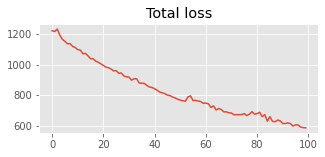

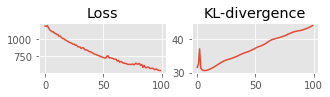

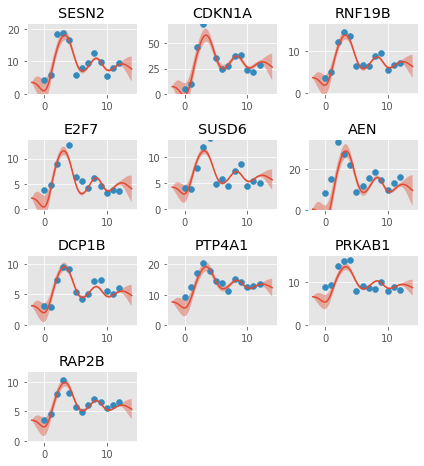

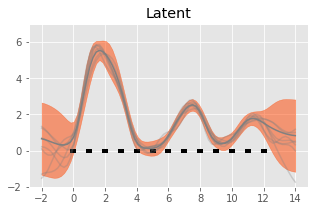

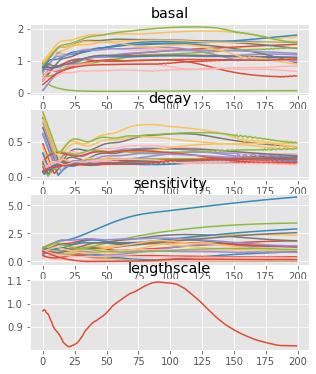

In [7]:
plotter.plot_losses(trainer, last_x=100)
plotter.plot_outputs(t_predict, replicate=0, t_scatter=t_observed,y_scatter=m_observed, model_kwargs=model_kwargs)
plotter.plot_latents(t_predict, ylim=(-2, 7), plot_inducing=False)
plotter.plot_convergence(trainer)

In [7]:
save(model, 'nonlinear')

In [8]:
do_load = False
if do_load:
    model = load('nonlinear', NonLinearLFM, num_genes, num_tfs,
                 t_inducing, dataset, extra_points=2, fixed_variance=dataset.variance)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    trainer = TranscriptionalTrainer(model, optimizer, dataset)
